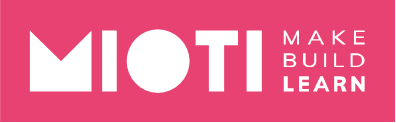
<br/>
<center style="color:#888">Master Deep Learning<br/>Asignatura Computer Vision</center>
<center style="color:#aaa; margin-top:10px;">Prof. Óscar Picazo Montoya<br>oscarpm@faculty.mioti.es</center>




# Práctica: "Fine-tuning" en redes neuronales de clasificación de imágenes

## Objetivos

El objetivo de esta práctica es que aprendas cómo reutilizar un modelo de red neuronal convolucional preentrenado con unas clases y lo vuelvas a entrenar para reconocer un conjunto de clases diferentes al original.

## Configuración del entorno

In [1]:
%matplotlib inline

import os

# Si queremos evitar los Warnings que provoca la nueva librería de tensorflow si no tenemos
# una GPU disponible, podemos descomentar la siguiente línea:

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data, io, filters
from skimage import transform

import tensorflow as tf

import cv2

import mioti.cnn.cv as mcv

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Si tenemos una GPU NVIDIA podemos evitar que tensorflow la use descomentando la línea siguiente:

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Dataset

Para la práctica nos han proporcionado tres vídeos en formato MPEG-4. Cada uno de los vídeos corresponde a cada clase que queremos reconocer.

El primer paso para afrontar este tipo de problema sería obtener un dataset de entrenamiento y validación de modo que nos permita poder entrenar una red neuronal convolucional. Se podría buscar por Internet si existe algún dataset que se pueda usar (atención a las licencias de uso, normalmente para investigación no suele haber problemas), podríamos comprarla si alguien la proporciona, podríamos encargar la creación del dataset a un tercero, o incluso lo podríamos crear nosotros mismos. En nuestro caso vamos a aprovecharnos de los vídeos que nos han dado.

Ya se ha trabajado en la asignatura la forma de procesar cada "frame" o fotograma en un vídeo utilizando la librería "opencv". Un código que podría crear un "dataset" de imágenes a partir de un vídeo por cada clase podría ser el siguiente:

In [2]:
from os import listdir, mkdir
from os.path import isfile, join, basename, splitext
import shutil

def creaDatasetAPartirDeVideos (dir_videos, dir_dataset):
    
    try:
        print ("Creando directorio para el Dataset: ", dir_dataset, ":")
        mkdir(dir_dataset)
    except Exception as ex:
        print ("Error creando el directorio '", dir_dataset, "' con Excepción: ", ex)
            
    for f in listdir(dir_videos): 
        filename = join(dir_videos, f)
        if isfile(filename):
            video = None
            try:
                
                nframe = 0
                video = cv2.VideoCapture(filename)
                filename_splited = splitext(basename(filename))
                nombre_clase = filename_splited[0]
                dir_clase = join (dir_dataset, nombre_clase)
                
                try:
                    print (nombre_clase, ": ", end="")
                    mkdir(dir_clase)
                except Exception as ex:
                    print ("Error creando el directorio '", dir_clase, "' con Excepción: ", ex)
                    
                while True:
                    
                    ret, frame = video.read()
                    if not ret:
                        break
                    else:
                        nombre_imagen = join (dir_clase, "img{:08}.jpg".format(nframe))

                        cols = frame.shape[1]
                        fils = frame.shape[0]

                        if cols > fils:
                            # la imagen es más ancha que alta
                            ini = int((cols / 2) - (fils / 2))
                            end = int(ini + fils)
                            frame_new = frame[:,ini:end,:]
                        else:
                            # la imagen es más alta que ancha
                            ini = int((fils / 2) - (cols / 2))
                            end = int(ini + cols)
                            frame_new = frame[ini:end,:,:]

                        cv2.imwrite (nombre_imagen, frame_new)
                        
                    nframe = nframe + 1
                
                print (": {}".format(nframe))
                video.release()
                video = None
            except Exception as ex:
                print("Error al procesar el vídeo: ", filename, " - Excepción: ", ex)
                if video != None:
                    video.release()

In [3]:
creaDatasetAPartirDeVideos ("videos", "dataset")

Creando directorio para el Dataset:  dataset :
Cebolla : : 672
Manzana : : 565
Naranja : : 478


Algo importante que debemos tener en cuenta a la hora de entrenar el modelo es si las clases están o no balanceadas (el número de imágenes por clase). Si tenemos muchas más imágenes de una clase que de otra se puede introducir cierto sesgo en el modelo hacia la clase mayoritaria. 

Opciones para balancear los datos puede ser por ejemplo aplicar "data augmentation" (en imágenes hablamos de escalado de imágenes, rotación y espejo, tanto vertical como horizontal). Otra opción es eliminar imágenes de las clases mayoritarias hasta igualar el número de imágenes por clase, esto se puede hacer cuando el número de imágenes es muy grande.

En nuestro caso están más o menos balanceadas, no obstante, si vemos que el resultado tiene cierto sesgo y predecimos la clase mayoritaria, tendremos que tratar este problema.

Adicionalmente vemos que el número de imágenes que disponemos para entrenar y validar el nuevo modelo que queremos crear no es muy grande. Vamos a continuar creando tres copias de cada imagen en todos los modelos:

In [4]:
from os.path import isdir
from shutil import copyfile

def duplicaImagenesEnDataset (dir_dataset, copias):
    for d in listdir(dir_dataset):
        dir_clase = join(dir_dataset, d)
        if isdir(dir_clase):
            ficheros = 0
            print ("Directorio: ", dir_clase, end='')
            for f in listdir(dir_clase):
                filename_original = join(dir_clase, f)
                if isfile(filename_original):
                    ficheros = ficheros + 1
                    if filename_original.find('_copy_') == -1:
                        filename_splited = splitext(filename_original)
                        for n in range(copias):
                            try:
                                filename_copia = filename_splited[0] + "_copy_{}".format(n) + filename_splited[1]
                                if not isfile(filename_copia):
                                    copyfile(filename_original, filename_copia)
                                    ficheros = ficheros + 1
                            except Exception as ex:
                                None
            print (" - Ficheros: ", ficheros)        

In [5]:
duplicaImagenesEnDataset ("dataset", 3)

Directorio:  dataset\Cebolla - Ficheros:  2688
Directorio:  dataset\Manzana - Ficheros:  2260
Directorio:  dataset\Naranja - Ficheros:  1912


El problema de duplicar imágenes es que realmente, lo normal, es que no ayuden a obtener un mejor modelo entrenado. Habría sido mejor opción aplicar algún tipo de transformación con las técnicas anteriormente mencionadas de "data augmentation" en imágenes. 

Realmente sí vamos a utilizar esta técnica, pero nos aprovecharemos del nuevo modelo que creemos a través del uso de ciertas capas que proporciona <i>keras</i>.

## Carga de datos de entrenamiento y test



Para la carga del dataset de entrenamiento y validación <i>keras</i> nos proporciona la función <i>image_dataset_from_directory</i>, vamos a ver cómo se utiliza:

In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

TRAIN_DIR = './dataset'
IMG_SIZE = (224,224)
BATCH_SIZE = 8 # MIO-ESTE BACH_SIZE ES PARA EL DATA SET. INDICA LAS IMAGENES EN MEMORIA ES DISTINTO AL DE LA RED, AUNQUE SE SUELEN SINCRONIZAR UNO Y OTRO
#Y SE PONE EL MISMO SIZE.

train_data = image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,#MIO- SIEMPRE SE INDICA EL PORCENTAJE DE VALIDACIÓN AUNQUE ESTEMOS EN TRAINNING
    image_size= IMG_SIZE,
    batch_size= BATCH_SIZE,
    shuffle = True,
    subset='training',
    seed = 123,
    label_mode = 'categorical',
)

valid_data = image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    image_size= IMG_SIZE,
    batch_size= BATCH_SIZE,
    shuffle = False,
    subset='validation',
    seed = 123,
    label_mode = 'categorical',
)

Found 6860 files belonging to 3 classes.
Using 5488 files for training.
Found 6860 files belonging to 3 classes.
Using 1372 files for validation.


Podemos recorrer el dataset cargado utilizando el siguiente código:

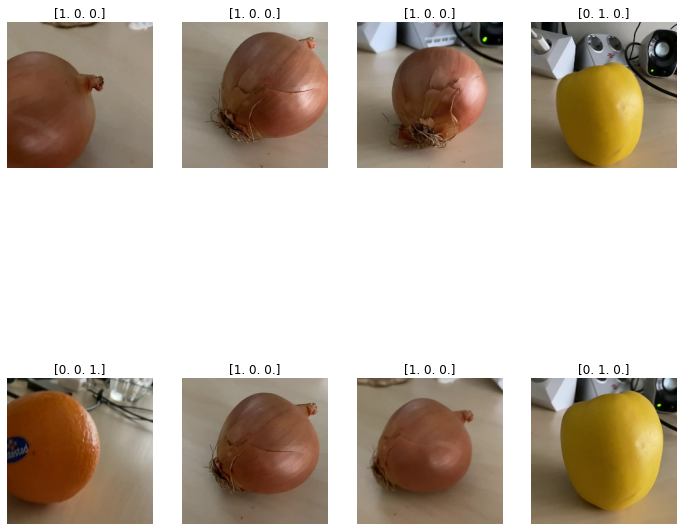

In [8]:
plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1): # MIO - NOS COGE EL NÚMERO DE IMAGENES QUE HEMOS CONFIGURADO EN BACH_SIZE
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(format(labels[i]))
        plt.axis("off")

Y también podemos obtener las clases que ha encontrado de la siguiente forma:

In [9]:
print (train_data.class_names)

num_clases = len(train_data.class_names)
print (num_clases)

['Cebolla', 'Manzana', 'Naranja']
3


Básicamente lo que hace la función <i>image_dataset_from_directory</i> de <i>keras</i> es buscar los directorios que existen dentro del directorio que hemos pasado como parámetro. Cada uno de esos directorios son las clases distintas que se van a crear y las imágenes por cada clase serían las que están dentro de esos directorios.

## Carga de modelos pre-entrenados

Al igual que hemos hecho en worksheet anteriores, vamos a cargar un modelo preentrenado con los pesos del challenge de ImageNet:

In [11]:
from keras.applications.vgg19 import VGG19

modelo_original = VGG19(weights='imagenet')

Normalmente los modelos permiten cargar la red preentrenada con unos pesos pero omitiendo las capas de clasificación (con "include_top=False" como parámetro en este caso). Adicionalmente también podemos cargarlo con un tamaño de imágenes específico (siempre que lo tengan disponible):

In [12]:
modelo_nuevo_parcial = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

80150528/80134624 [==============================] - 4s 0us/step


Comparemos las capas de ambos modelos:

In [14]:
modelo_original.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
modelo_nuevo_parcial.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Como podemos ver nos faltarían las 4 últimas capas, las de clasificación del modelo. 

A continuación vamos a crear nuevas capas al principio del modelo, que nos van a permitir tratar las imágenes de entrada. Como el número de imágenes de entrada para cada clase es pequeño hemos decidido crear 4 copias de cada una de las imágenes para ampliar el número de imágenes en el entrenamiento. Hemos decidido aplicar la técnica de "data augmentation" en el propio modelo en lugar de hacerlo sobre las imágenes directamente:

In [15]:
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19

inputs = tf.keras.Input(shape=(224, 224, 3))
x = layers.RandomFlip("horizontal")(inputs) #CAPAS QUE REALIZAN DATA AUGMENTATION SIMILAR ESTRATEGIA AL IMAGEDATGENERATOR
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)
x = preprocess_input_vgg19(x) #AQUI ESTAMOS APLICANDO EL PREPROCESADO QUE SE HIZO PARA LA VGG19. CADA MODELO TENDRÁ LA SUYA
x = modelo_nuevo_parcial(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_clases, activation='softmax')(x)
modelo_nuevo = tf.keras.Model(inputs, outputs)

Hemos creado también al final las capas de clasificación, primero la capa "Flatten" que se encarga de crear el vector de una sola dimensión con todas las características de la imagen que funcionará como entrada a una red neuronal totalmente conectada o perceptrón multicapa. La siguiente capa será una capa oculta con 512 neuronas de salida y con función de activación tipo 'relu'. A continuación añadimos una capa de "Dropout" con la que trataremos evitar el sobreaprendizaje de esta parte de la red. Por último introducimos otra capa con el número de clases del modelo (en este caso 3) con función de activación 'softmax'.

Vamos a ver las capas del nuevo modelo creado:

In [16]:
modelo_nuevo.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         200243

In [18]:
modelo_nuevo.layers[6].summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Para poder entrenar la red vamos a compilar el modelo:

In [15]:
modelo_nuevo.compile(
        optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"]
    )

Debido al tiempo que requiere el entrenamiento se ha especificado una variable "entrena_real" que con valor "False" nos muestra una imagen con el progreso de entrenamiento que se llevó a cabo y con "True" para que realmente se haga ese entrenamiento. De momento os recomiendo dejarlo a "False" y veamos el resultado:

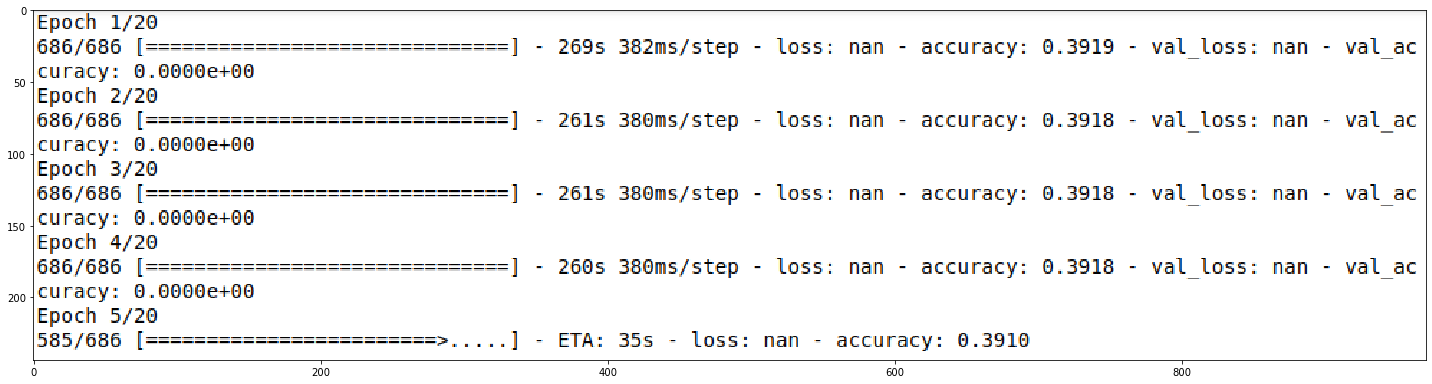

In [19]:
entrena_real = False

if entrena_real:
    history = modelo_nuevo.fit(train_data, validation_data=valid_data, epochs= 20, batch_size=BATCH_SIZE)
    history_data = history.history
else:
    img = io.imread("newmodel/VGG19-sgd-entrenamientotodaslascapas-batchsize8/Epochs.png")
    plt.figure(figsize=(20, 20))
    io.imshow(img)
    io.show()
    history_data = None

* **MIO**- ESTO NOS PASA POR QUE ESTAMOS ENTRANANDO TODOS LOS PESOS DE LA RED VGG19 Y TENEMOS MUY POCAS IMAGENES. NO ES CAPAZ DE ENTRENAR

<b>¿Qué os parece que sucedió en este entrenamiento? ¿por qué sucedió?</b>

Cuando no se consigue entrenar un modelo, se recomienda cambiar la función de optimización (parámetro <i>optimizer</i> cuando llamamos a <i>compile</i>). En este caso vamos a hacer el mismo experimento, pero usando la función de optimización "adam".

Prestar atención a la función <i>creaModeloConPesosImagenetParaEntrenar</i> definida en el módulo <i>cv.py</i> en el directorio <i>mioti/cnn/</i> y la anterior asignación a "None" de la variable <i>modelo_nuevo</i>:

<b>¿Por qué créis que es necesario estos pasos previos a volver a entrenar el modelo?</b>

In [20]:
modelo_nuevo = None # MIO- ES NECESARIO PARA DECIRLE A PYTHON QUE LIBERE EL OBJETO DE MEMORIA. SI NO SE PONE SEGURIA OCUPANDO MEMORIA HASTA QUE QUISIERA PYTHON

modelo_nuevo = mcv.creaModeloConPesosImagenetParaEntrenar ("VGG19", num_clases)

modelo_nuevo.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

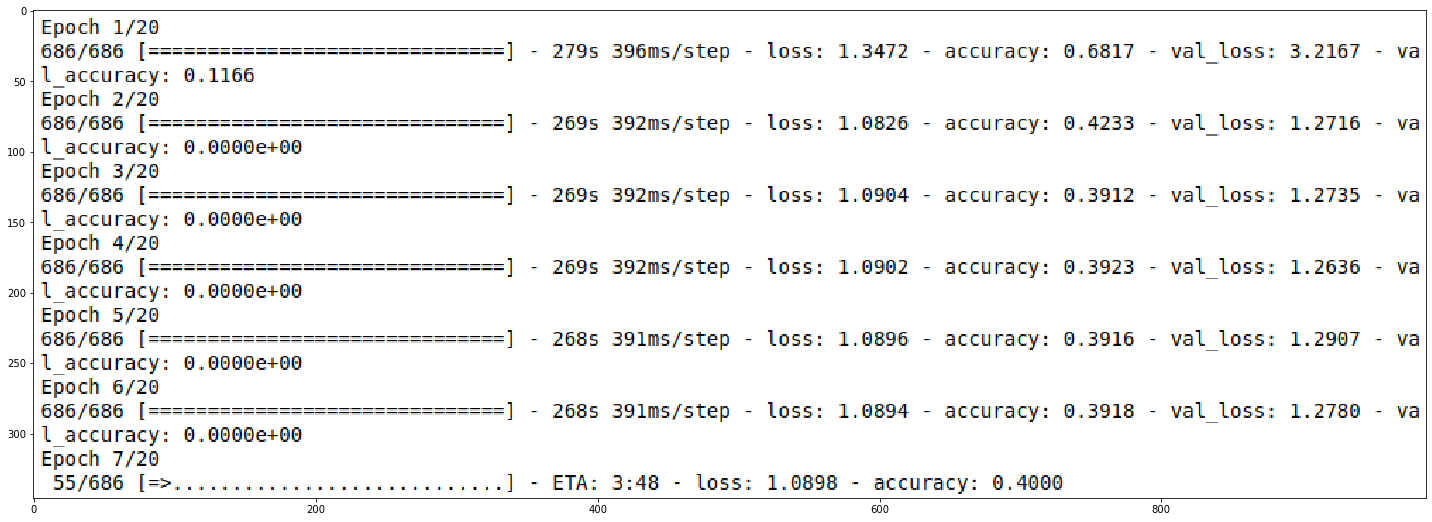

In [21]:
entrena_real = False

if entrena_real:
    history = modelo_nuevo.fit(train_data, validation_data=valid_data, epochs= 20, batch_size=BATCH_SIZE)
    history_data = history.history
else:
    img = io.imread("newmodel/VGG19-adam-entrenamientotodaslascapas-batchsize8/Epochs.png")
    plt.figure(figsize=(20, 20))
    io.imshow(img)
    io.show()
    history_data = None

La siguiente recomendación, visto que no conseguimos que se entrene el modelo, es aumentar el <i>batch_size</i> (cantidad de elementos del <i>dataset</i> de entrenamiento que usamos para el cálculo de pesos de forma simultánea en cada iteración del <i>epoch</i>) cuando llamamos a la función <i>fit</i> del modelo:

In [22]:
modelo_nuevo = None

modelo_nuevo = mcv.creaModeloConPesosImagenetParaEntrenar ("VGG19", num_clases)

modelo_nuevo.compile(
        optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"]
    )

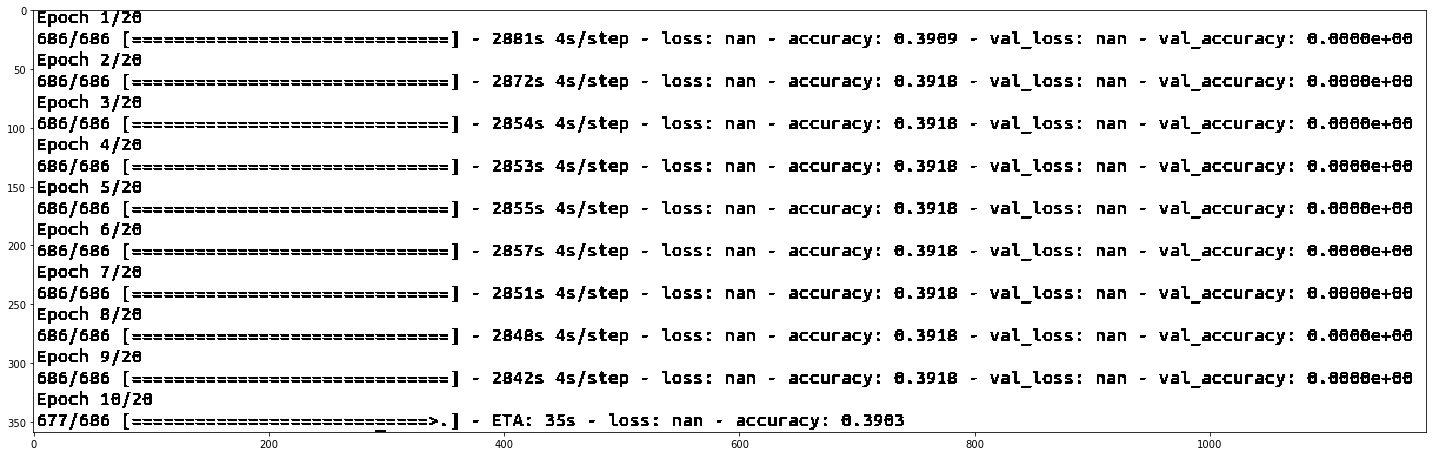

In [23]:
entrena_real = False

if entrena_real:
    history = modelo_nuevo.fit(train_data, validation_data=valid_data, epochs= 20, batch_size=64)
    history_data = history.history
else:
    img = io.imread("newmodel/VGG19-sgd-entrenamientotodaslascapas-batchsize64/Epochs.png")
    plt.figure(figsize=(20, 20))
    io.imshow(img)
    io.show()
    history_data = None

Todos estos experimentos que hemos realizado nos ha permitido ver que el modelo no consigue calcular los pesos en la red que permita ir mejorando el <i>accuracy</i> en el <i>dataset</i> de entrenamiento. **El problema principal por lo que ocurre esto es porque el número de imágenes que tenemos en el <i>dataset</i> no es suficiente para entrenar el modelo completo, todas las capas. Quizás si creamos un modelo más pequeño podríamos conseguir mejores resultados, aunque tampoco lo tenemos seguro, solamente se podría comprobar mediante experimentación.**

**Continuaremos haciendo algo que se suele hacer en esto casos, congelar algunas capas del modelo** y entrenar solamente la parte de la red que se encarga de la clasificación, es decir las capas que hemos añadido al final de la red. Para esto cada capa tiene una propiedad <i>trainable</i> que permite con el valor <i>False</i> indicar al algoritmo de clasificación que no cambie los pesos de esa capa en el entrenamiento. Con esto también conseguiremos de el entrenamiento sea más rápido, ya que existen pesos que no es necesario cambiar en cada iteración.

Con el siguiente código podemos congelar las capas que corresponden a la red VGG19 en nuestro modelo de prueba:

In [24]:
modelo_nuevo = None

modelo_nuevo = mcv.creaModeloConPesosImagenetParaEntrenar ("VGG19", num_clases)

for layer in modelo_nuevo.layers[6].layers: # LAYER 6 ES LA ÚLTIMA CAA PROPIA DE LA VGG19
    layer.trainable = False

Indicamos la función de optimización a usar, la función de pérdida y la métrica que usaremos en el entrenamiento y validación:

In [25]:
modelo_nuevo.compile(
        optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"]
    )

Observar el código que se encarga de entrenar el modelo porque tiene varias cosas interesantes:

- Primero el uso de la variable <i>entrena_real</i>, al igual que en los casos anteriores con <i>False</i> indicamos que no queremos entrenarla y <i>True</i> en caso contrario. Al igual que antes, el entrenamiento tomará mucho tiempo por lo que debemos armarnos de paciencia o de un equipo con una buena tarjeta gráfica.

- Si nos centramos en la parte de entrenamiento real:

  - Llamamos a <i>fit</i> para entrenar.
  - Creamos un fichero 'history.bin' en el directorio 'newmodel' en modo escritura de datos binarios (parámetro 'wb' en la llamada a <i>open</i>).
  - Escribimos los datos del objeto <i>history.history</i> ayudándonos de la librería <i>pickle</i> y usando la función <i>dump</i> (esta función almacena de forma binaria un objeto en un fichero de tal forma que después podamos recuperarlo). Estos datos contienen los resultados del entrenamiento por cada <i>epoch</i>.
  - Cerramos el fichero.
  
  - Creamos un fichero 'model.json' en el directorio 'newmodel' en modo escritura de datos de texto (parámetro 'w' en la llamada a <i>open</i>, fijaros en la diferencia con la creación del fichero anterior).
  
  - Un modelo de <i>keras</i> (en nuestro caso el que tenemos almacenado en <i>modelo_nuevo</i>) tiene disponible una función que trasforma el esqueleto del modelo en formato <i>JSON</i>. La función se llama <i>to_json</i> y retorna una variable de texto con el modelo en este formato. Este modelo <b>no</b> incluye los pesos internos de cada capa.
  
  - Escribimos el modelo en formato <i>JSON</i> en el fichero con la función <i>write</i> y cerramos el fichero.
  
  - Por último almacenamos los pesos que hemos entrenado en el modelo usando otra función que tienen disponibles los modelos de <i>keras</i> que se llama <i>save_weights</i>.

- En caso de no hacer el entrenamiento real:

  - Mostramos una imagen <i>PNG</i> con el resultado del entrenamiento real.
  
  - Abrimos el fichero 'model.json' con la función <i>open</i> en modo lectura de texto (con el parámetro 'r').
  
  - Leemos el contenido del fichero con la función <i>read</i> y lo asignamos al parámetro <i>model_json</i>.
  
  - Cerramos el fichero y creamos un modelo de <i>keras</i> a partir de una variable de texto en formato <i>JSON</i> con la función <i>model_from_json</i> especificada dentro del módulo <i>tf.keras.models</i>.
  
  - Cargamos los pesos del modelo usando la función <i>load_weights</i> disponibles en los modelos en <i>keras</i>.
  
  - Compilamos el modelo con los parámetros que usamos en el entrenamiento (esto es necesario porque después vamos a realizar una validación final del modelo con <i>evaluate</i> si solamente fuésemos a usar el modelo para llamar a <i>predict</i> no sería necesario).
  
  - Abrimos el fichero 'history.bin' esta vez para lectura en modo binario (con la opción 'rb').
  
  - Usando la librería <i>pickle</i> leemos el objeto que guardamos en el entrenamiento real utilizando la función <i>load</i>. Recordad que este objeto almacenaba los resultados de cada <i>epoch</i> en el entranamiento.
  
  - Por último cerramos el fichero.

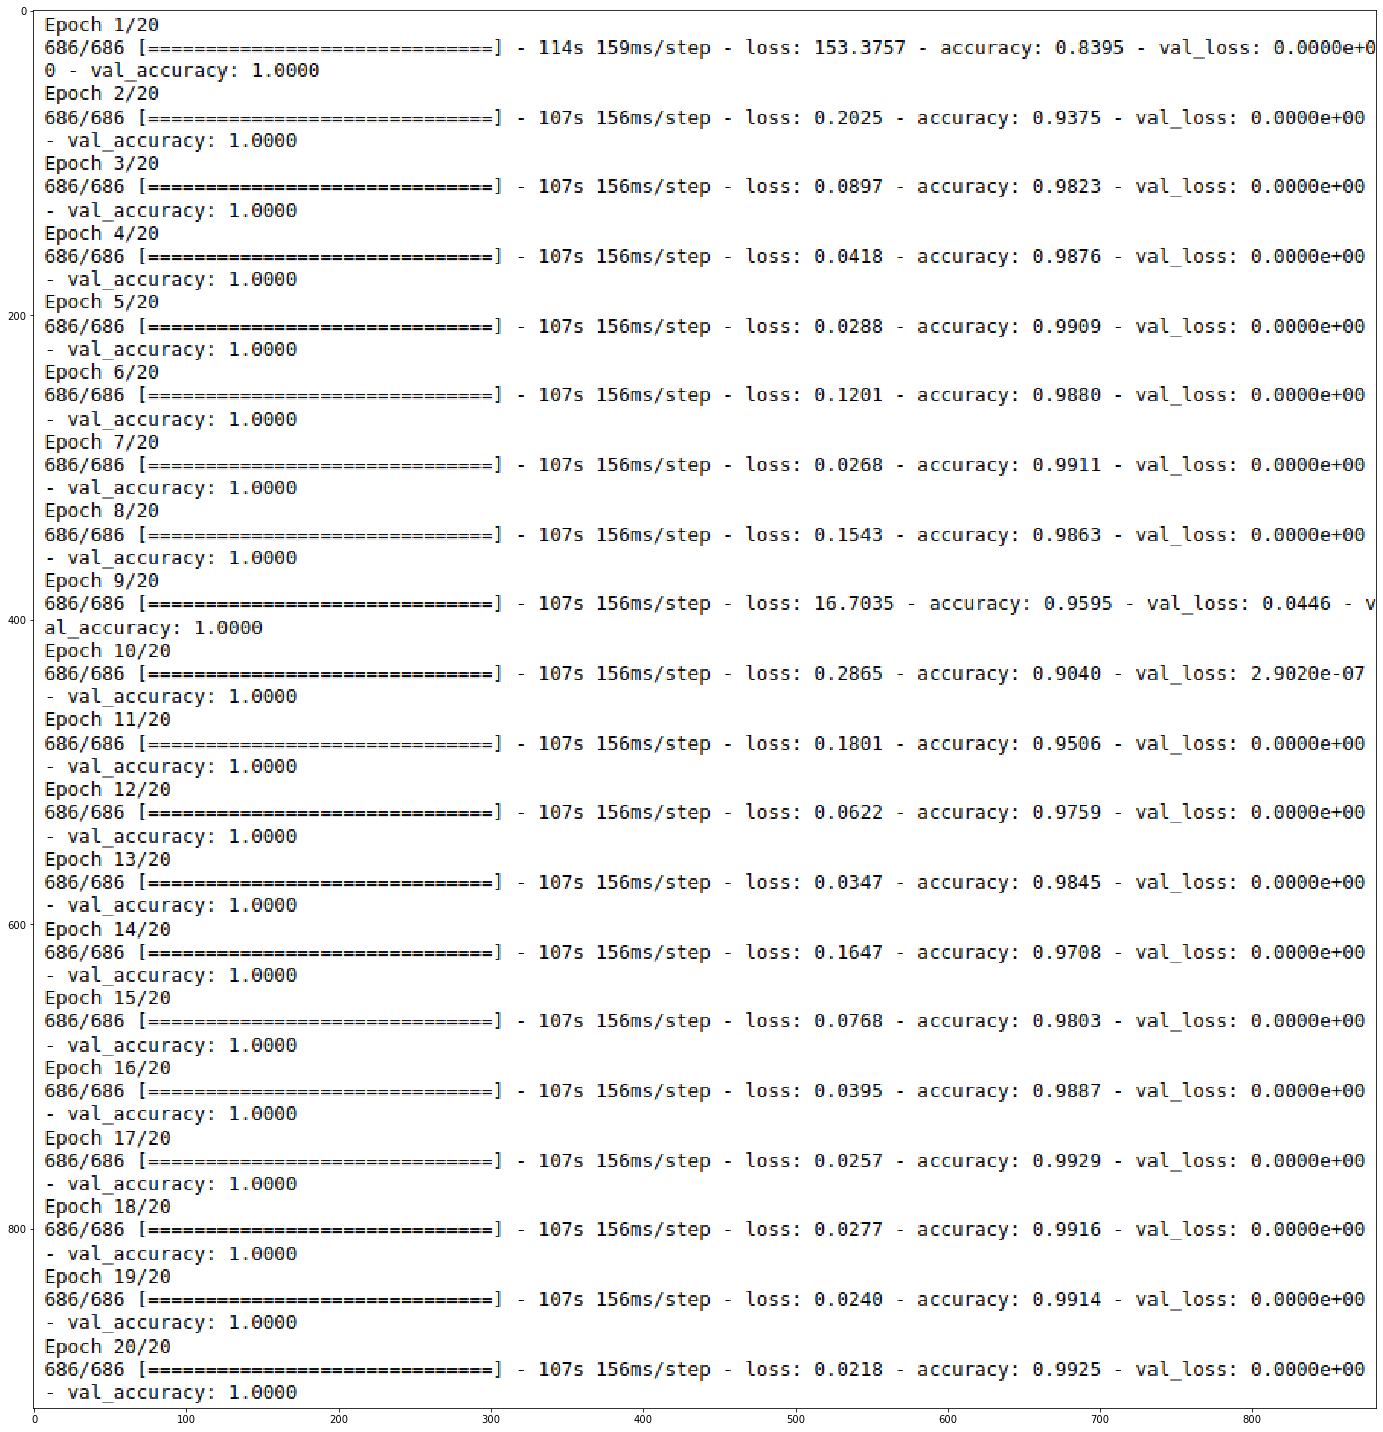

In [27]:
import pickle

entrena_real = False

if entrena_real:
    history = modelo_nuevo.fit(train_data, validation_data=valid_data, epochs= 20, batch_size=BATCH_SIZE)
    history_data = history.history
    
    with open('newmodel/history.bin', 'wb') as history_file:
        pickle.dump(history_data, history_file)
        history_file.close()
    model_json = modelo_nuevo.to_json()
    with open("newmodel/model.json", "w") as json_file:
        json_file.write(model_json)
        json_file.close()
    modelo_nuevo.save_weights("newmodel/model.h5")
    
else:
    img = io.imread("newmodel/VGG19-sgd-entrenamientosoloultimascapas-batchsize8/Epochs.png")
    plt.figure(figsize=(20, 20))
    io.imshow(img)
    io.show()
    history_data = None
    
    json_file = open('newmodel/VGG19-sgd-entrenamientosoloultimascapas-batchsize8/model.json', 'r')
    model_json = json_file.read()
    json_file.close()
    modelo_nuevo = None
    modelo_nuevo = tf.keras.models.model_from_json(model_json)# MIO - CON EL ESQUELETO JSON KERAS INSTANCIA DINAMICAMENTE EL MODELO.
    modelo_nuevo.load_weights("newmodel/VGG19-sgd-entrenamientosoloultimascapas-batchsize8/model.h5") # CARGAMOS LOS PESOS.
    
    modelo_nuevo.compile(
        optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    history_file = open('newmodel/VGG19-sgd-entrenamientosoloultimascapas-batchsize8/history.bin', 'rb')
    history_data = pickle.load(history_file)
    history_file.close()

Mostramos la evocución del entrenamiento usando el objeto <i>history_data</i> y la función <i>muestraGraficasDelHistoricoDeEntrenamiento</i> que tenemos definida en el módulo <i>mioti.cnn.cv</i>:

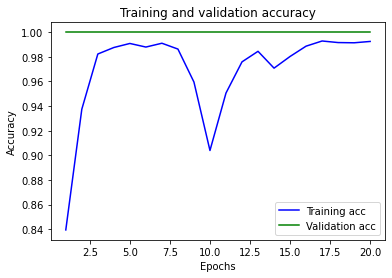

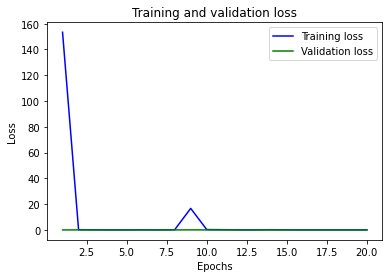

In [28]:
mcv.muestraGraficasDelHistoricoDeEntrenamiento (history_data)

* QUE LOS DATOS DE VALIDACIÓN SEAN TAN PROXIMOS A 1 EN ACURRACY Y EL LOSS TAN BAJO NO ES MALO.
* SIN EMBARGO SI ESTOS VALORES SE DIERAN EN LA PARTE TRAIN SI SERÍA UN INDICADOR CLARO DE SOBREAJUSTE.

Evaluamos el modelo final:

In [41]:
scores = modelo_nuevo.evaluate(valid_data)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

172/172 [==============================] - 21s 123ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test loss: 0.0
Test accuracy: 1.0


En el directorio 'newmodel/test-images' existen 7 imágenes que no han entrado en el entrenamiento ni la validación del modelo. Fueron tomadas con cámaras distintas y si os fijáis en el fondo de las imágenes es diferente al fondo que se usaron en los vídeos que hemos utilizado para el entrenamiento del modelo.

Para ver el resultado por cada imagen hemos propuesto el siguiente código:

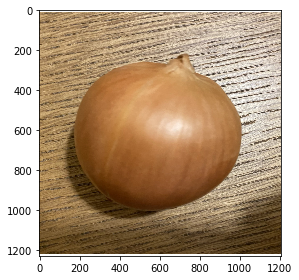

(1227, 1209, 3)
Predicted: [[1. 0. 0.]]


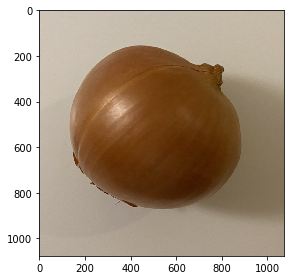

(1077, 1074, 3)
Predicted: [[9.7687554e-01 2.2729831e-02 3.9469730e-04]]


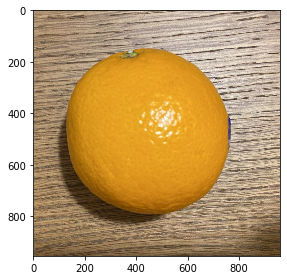

(954, 960, 3)
Predicted: [[0. 0. 1.]]


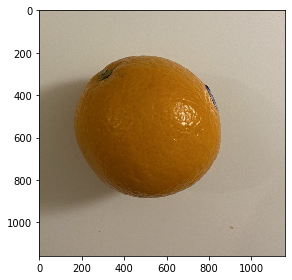

(1158, 1158, 3)
Predicted: [[2.960516e-11 5.506624e-15 1.000000e+00]]


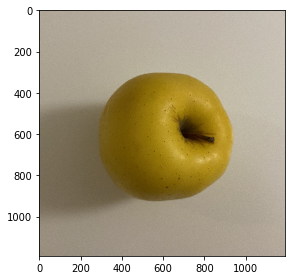

(1191, 1191, 3)
Predicted: [[0. 1. 0.]]


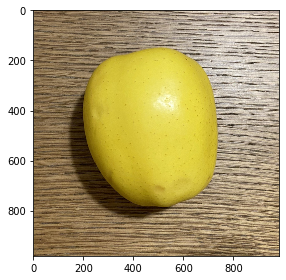

(981, 984, 3)
Predicted: [[9.1796076e-10 1.0000000e+00 2.0591575e-09]]


In [42]:
for i in range(1,7):
    img = io.imread('newmodel/test-images/{}.jpg'.format(i))
    io.imshow(img)
    io.show()
    img_resized = transform.resize(img, (224, 224), preserve_range=True)
    img_expanded = np.expand_dims(img_resized, axis=0)
    img_preprocessed = preprocess_input_vgg19(img_expanded)
    preds = modelo_nuevo.predict(img_preprocessed)
    print(img.shape)
    print('Predicted: {}'.format(preds))

Podemos repetir todos los pasos anteriores, desde la parte de congelación de capas para el modelo original, pero esta vez para una red distinta a <i>VGG19</i>, por ejemplo la <i>EfficientNetB0</i>:

In [27]:
modelo_nuevo = None

modelo_nuevo = mcv.creaModeloConPesosImagenetParaEntrenar ("EfficientNetB0", num_clases)

for layer in modelo_nuevo.layers[4].layers:
    layer.trainable = False

Veamos el resumen del modelo:

In [28]:
modelo_nuevo.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_4 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 3843

<b>¿qué diferencias encontráis con el modelo <i>VGG19</i> anterior?</b>

In [29]:
modelo_nuevo.compile(
        optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"]
    )

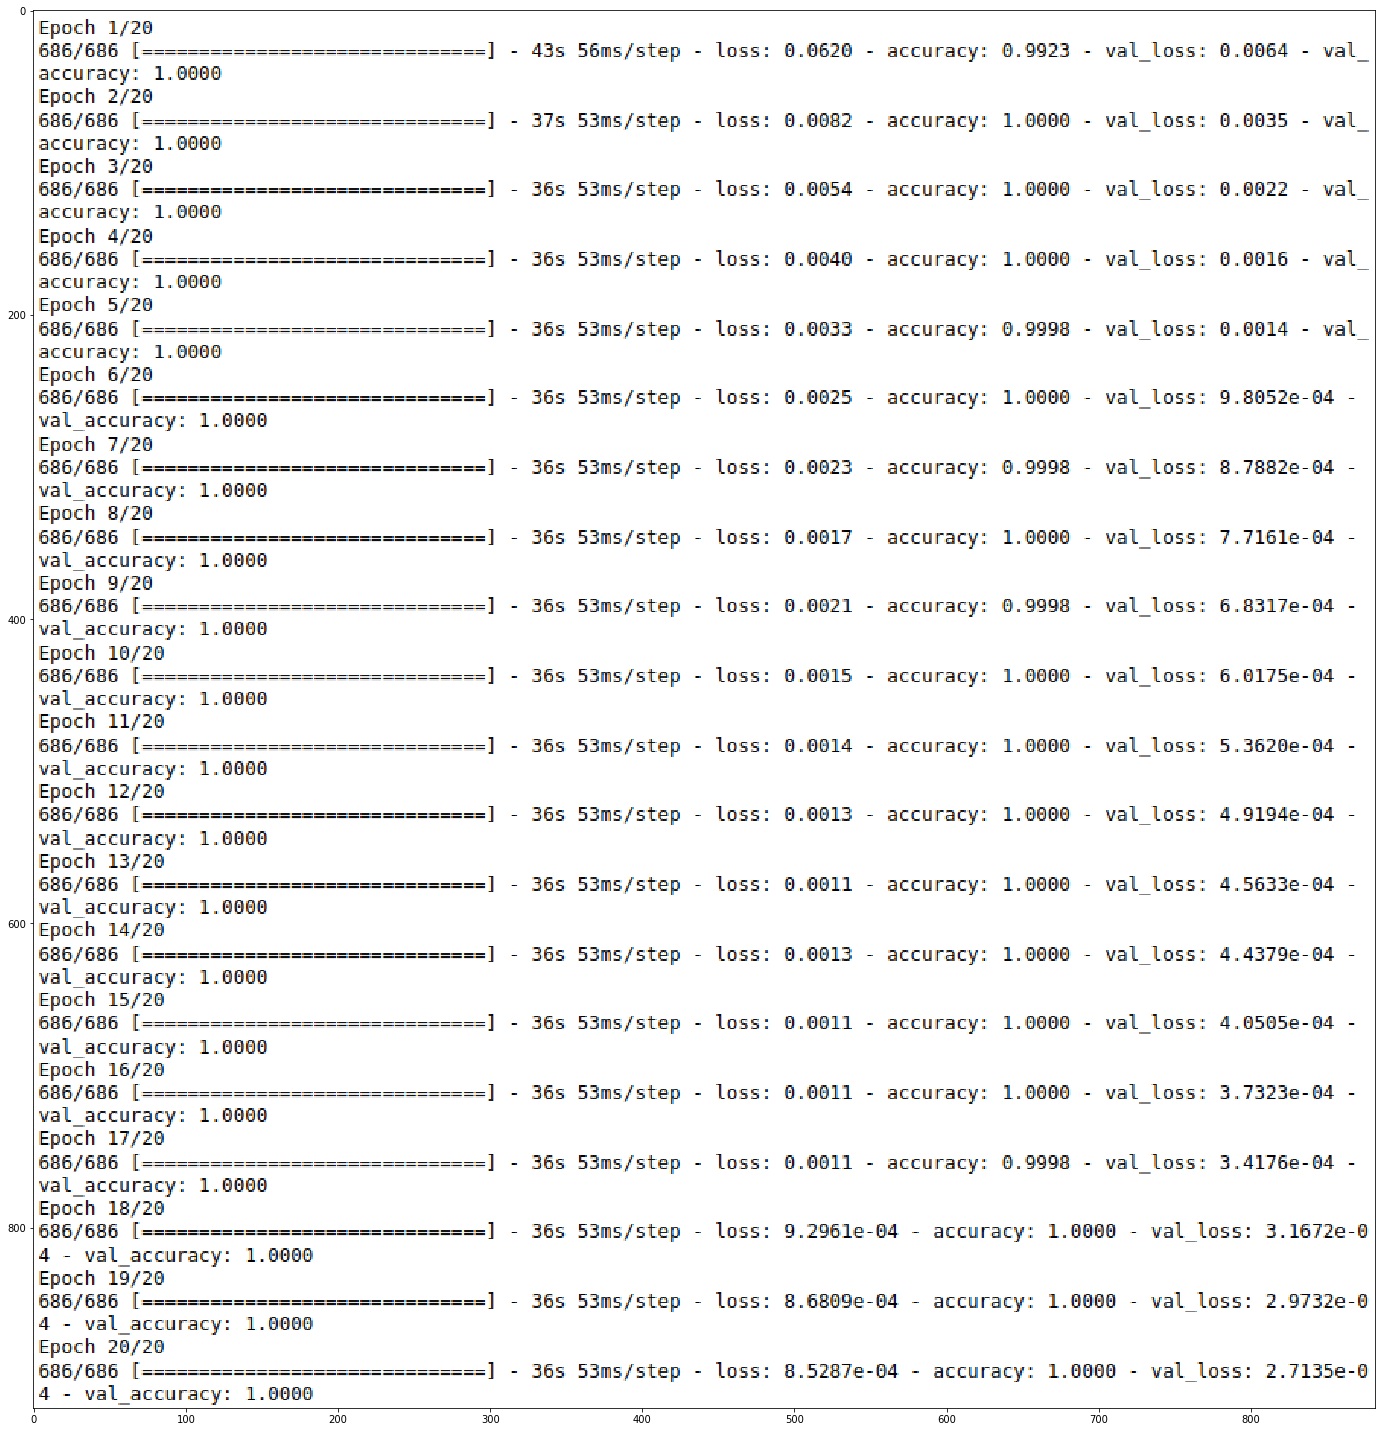

In [30]:
entrena_real = False

if entrena_real:
    history = modelo_nuevo.fit(train_data, validation_data=valid_data, epochs= 20, batch_size=BATCH_SIZE)
    history_data = history.history
    
    with open('newmodel/history.bin', 'wb') as history_file:
        pickle.dump(history_data, history_file)
        history_file.close()
    model_json = modelo_nuevo.to_json()
    with open("newmodel/model.json", "w") as json_file:
        json_file.write(model_json)
        json_file.close()
    modelo_nuevo.save_weights("newmodel/model.h5")
    
else:
    img = io.imread("newmodel/EfficientNetB0-sdg-entrenamientosoloultimascapas-batchsize8/Epochs.png")
    plt.figure(figsize=(20, 20))
    io.imshow(img)
    io.show()
    history_data = None
    
    json_file = open('newmodel/EfficientNetB0-sdg-entrenamientosoloultimascapas-batchsize8/model.json', 'r')
    model_json = json_file.read()
    json_file.close()
    modelo_nuevo = None
    modelo_nuevo = tf.keras.models.model_from_json(model_json)
    modelo_nuevo.load_weights("newmodel/EfficientNetB0-sdg-entrenamientosoloultimascapas-batchsize8/model.h5")
    
    modelo_nuevo.compile(
        optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    history_file = open('newmodel/EfficientNetB0-sdg-entrenamientosoloultimascapas-batchsize8/history.bin', 'rb')
    history_data = pickle.load(history_file)
    history_file.close()

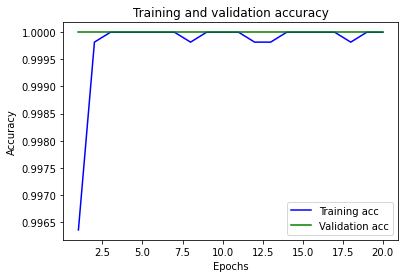

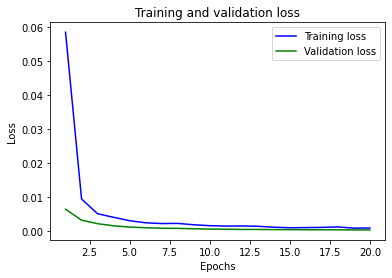

In [31]:
mcv.muestraGraficasDelHistoricoDeEntrenamiento (history_data)

Evaluamos el modelo final con el <i>dataset</i> de validación:

In [32]:
scores = modelo_nuevo.evaluate(valid_data)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

172/172 [==============================] - 10s 43ms/step - loss: 0.0101 - accuracy: 1.0000
Test loss: 0.010143325664103031
Test accuracy: 1.0


Comprobamos los resultados con la imágenes nuevas de test que no habíamos usado hasta ahora en el modelo:

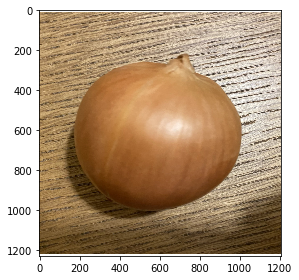

(1227, 1209, 3)
Predicted: [[0.9176848  0.07804662 0.00426868]]


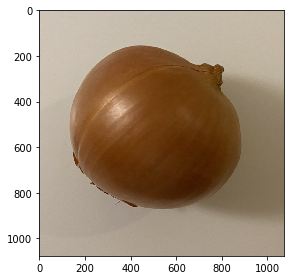

(1077, 1074, 3)
Predicted: [[0.78196675 0.20743817 0.01059507]]


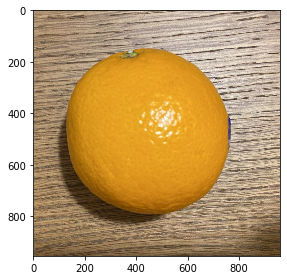

(954, 960, 3)
Predicted: [[3.2499648e-04 7.2598569e-02 9.2707640e-01]]


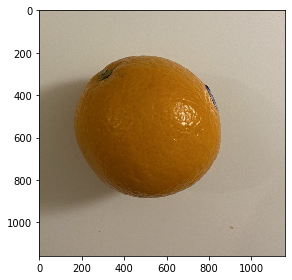

(1158, 1158, 3)
Predicted: [[1.7182450e-04 4.2398092e-03 9.9558842e-01]]


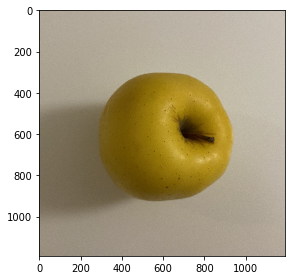

(1191, 1191, 3)
Predicted: [[0.00180007 0.9963846  0.00181525]]


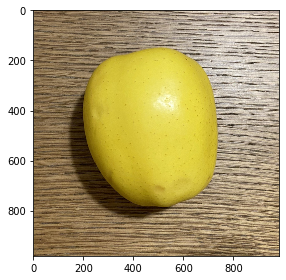

(981, 984, 3)
Predicted: [[3.8682389e-05 9.9984515e-01 1.1612782e-04]]


In [33]:
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet

for i in range(1,7):
    img = io.imread('newmodel/test-images/{}.jpg'.format(i))
    io.imshow(img)
    io.show()
    img_resized = transform.resize(img, (224, 224), preserve_range=True)
    img_expanded = np.expand_dims(img_resized, axis=0)
    img_preprocessed = preprocess_input_efficientnet(img_expanded)
    preds = modelo_nuevo.predict(img_preprocessed)
    print(img.shape)
    print('Predicted: {}'.format(preds))

Por último hemos creado una clase <i>ModeloPractica</i> que permite usar nuestro modelo entrenado en cualquier código de <i>python</i> siempre distribuyendo los ficheros 'mioti/cnn/cv.py', el esqueleto del modelo en formato <i>JSON</i> 'model.json' y los pesos del modelo entrenado 'model.h5' (podéis ver el código de la clase <i>ModeloPractica</i> en el fichero 'mioti/cnn/cv.py'):

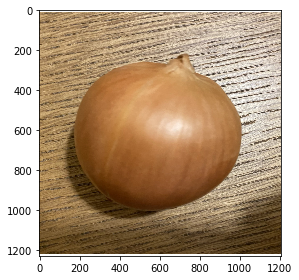

(1227, 1209, 3)
Predicted: [[1. 0. 0.]]


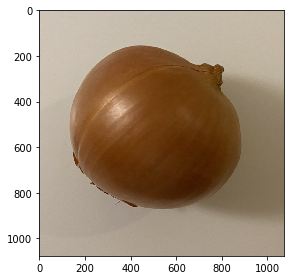

(1077, 1074, 3)
Predicted: [[1. 0. 0.]]


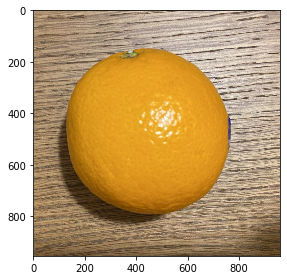

(954, 960, 3)
Predicted: [[0. 0. 1.]]


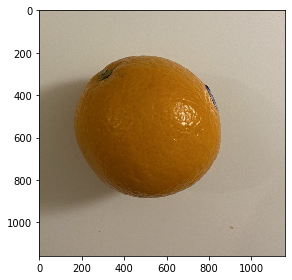

(1158, 1158, 3)
Predicted: [[0. 0. 1.]]


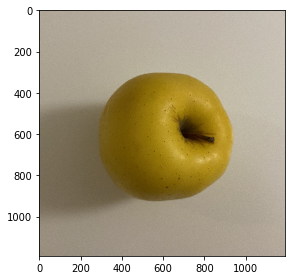

(1191, 1191, 3)
Predicted: [[0. 1. 0.]]


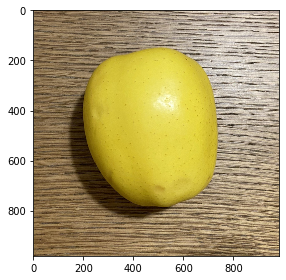

(981, 984, 3)
Predicted: [[0. 1. 0.]]


In [35]:
modelo = None
#modelo = mcv.ModeloPractica("EfficientNetB0")
modelo = mcv.ModeloPractica("VGG19")

for i in range(1,7):
    img = io.imread('newmodel/test-images/{}.jpg'.format(i))
    io.imshow(img)
    io.show()
    img_resized = transform.resize(img, (224, 224), preserve_range=True)
    img_expanded = np.expand_dims(img_resized, axis=0)
    img_preprocessed = modelo.preprocess_input(img_expanded)
    preds = modelo.get_model().predict(img_expanded)
    print(img.shape)
    print('Predicted: {}'.format(preds))